In [1]:
pip install -q mediapipe

Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests

url = 'https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task'
filename = 'pose_landmarker.task'

response = requests.get(url)
with open(filename, 'wb') as file:
    file.write(response.content)
print(f"Downloaded {filename}")


Downloaded pose_landmarker.task


In [26]:
#@markdown To better demonstrate the Pose Landmarker API, we have created a set of visualization tools that will be used in this colab. These will draw the landmarks on a detect person, as well as the expected connections between those markers.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

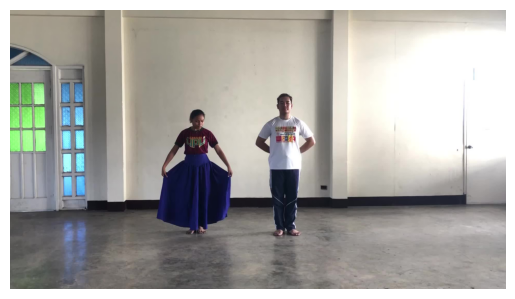

In [5]:
import cv2
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread("0001.jpg")

# Check if the image was loaded successfully
if img is None:
    print("Error: Unable to read the image file.")
else:
    # Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image using Matplotlib
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide the axis
    plt.show()


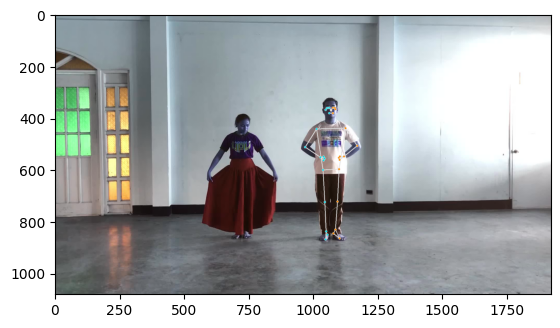

In [27]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("0001.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

In [29]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

packet = mp.Packet()

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    running_mode=mp.tasks.vision.RunningMode.VIDEO,
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input Video
# Use OpenCV’s VideoCapture to load the input video.
cap = cv2.VideoCapture("vid01.mp4")

# Load the frame rate of the video using OpenCV’s CV_CAP_PROP_FPS
# You’ll need it to calculate the timestamp for each frame.
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_duration = int(1000 / fps)  # Frame duration in milliseconds
timestamp = 0  # Initialize timestamp

# Loop through each frame in the video using VideoCapture#read()
while cap.isOpened():
    # Read a single frame from the video
    ret, frame = cap.read()
    
    # Check if frame reading was successful
    if not ret:
        break
    
    # Convert the frame received from OpenCV to a MediaPipe’s Image object.
    # Assuming you have already installed numpy and imported it
    numpy_frame_from_opencv = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=numpy_frame_from_opencv)

    # STEP 4: Detect pose landmarks from the input image.
    detection_result = detector.detect_for_video(image, fps)

    # STEP 5: Process the detection result. In this case, visualize it.
    annotated_frame = draw_landmarks_on_image(numpy_frame_from_opencv, detection_result)
    annotated_frame_bgr = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)

    # Display the annotated frame
    cv2.imshow('Pose Landmarker', annotated_frame_bgr)
    
    # Increment the timestamp
    timestamp += frame_duration
    
    # Break the loop if the 'q' key is pressed
    if cv2.waitKey(frame_duration) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


ValueError: Input timestamp must be monotonically increasing.